# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import time
from pathlib import Path
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
%matplotlib inline
%config InlineBackend.figure_format='retina'
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

import joblib

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras.layers import Input,Dropout,BatchNormalization,Activation,Dense,Concatenate,Add,Average
from keras.layers import GlobalAveragePooling1D,Bidirectional,LSTM,Conv1D,MaxPooling1D
from keras.models import Model

import copy

In [ ]:
import time
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
class LR_ASK(tf.keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.75): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor

    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to'
            print(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print(msg)
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss
            pimprov=(deltav/self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print(msg) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print(msg) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights

        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print(msg) # cyan foreground
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print(msg) # cyan foreground

# Dati SENZA test_set

In [4]:
# SENZA TEST SET
# This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains.
# The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
path = '/content/drive/MyDrive/ch2/'
df_categories = np.load(path + 'categories.npy') #48000 righe, ognuna con una lettera che mi dice la classe , da A ad F
df_training_data = np.load(path + 'training_data.npy') #48000rows-2776cols, una matrice di osservazioni 2776 per 48000 campioni
df_valid_periods = np.load(path + 'valid_periods.npy') #48000rows-2cols, matrice che mi dice colonna di partenza e di fine in cui training_data!=0

# What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set.

In [81]:
# SENZA TEST SET
# SENZA TEST SET
def build_sequences(df, df_categories, window=209, stride=60, min_length=30):
    dataset = []
    categories = []

    # Funzionamento: prendo una serie e voglio far scorrere una finestra lunga window sulla serie che ogni volta scorre indietro di lunghezza stride
    # Quando sforo nella parte di zeri mi fermo e prendo degli zeri
    for i in range(df.shape[0]):
        idx_first = np.nonzero(df[i,:])[0][0]
        idx_last = np.nonzero(df[i,:])[0][-1]
        row = df[i,idx_first:idx_last]

        if row.shape[0]<window:
          if row.shape[0]>min_length:
            dataset.append(np.concatenate((np.zeros(window-row.shape[0],dtype='float32'),row)))
            categories.append(df_categories[i])
          else: continue
        else: #row.shape[0]<window:
            save_first_samples = copy.copy(row[:window])
            while row.shape[0]>=window:
                dataset.append(row[-window:])
                categories.append(df_categories[i])
                row = row[:-stride]
            if row.shape[0]>0:
                dataset.append(np.concatenate((row,save_first_samples[row.shape[0]:window])))
                categories.append(df_categories[i])

    dataset = np.expand_dims(np.array(dataset),axis=-1)
    categories = np.expand_dims(np.array(categories),axis=-1)

    return dataset, categories

# BUILD DATASET
telescope = 18
window = 200 + telescope
stride = 70
random_state = 666
print('Seed for train_test_split is: ', random_state)
train_data, val_data, train_cat, val_cat = train_test_split(df_training_data, df_categories, test_size = 0.1, random_state = random_state)

dff_train, categories_letters_train = build_sequences(train_data, train_cat, window, stride)
dff_val, categories_letters_val = build_sequences(val_data, val_cat, window, stride)

categories_list = np.unique(df_categories)

class_mapping = {
            'A': [1, 0, 0, 0, 0, 0],
            'B': [0, 1, 0, 0, 0, 0],
            'C': [0, 0, 1, 0, 0, 0],
            'D': [0, 0, 0, 1, 0, 0],
            'E': [0, 0, 0, 0, 1, 0],
            'F': [0, 0, 0, 0, 0, 1],
            }
categories_cat_train = []
for i in range(categories_letters_train.shape[0]):
  categories_cat_train.append(class_mapping.get(categories_letters_train[i][0], -1))
categories_cat_train = np.expand_dims(np.array(categories_cat_train), -1)

categories_cat_val = []
for i in range(categories_letters_val.shape[0]):
  categories_cat_val.append(class_mapping.get(categories_letters_val[i][0], -1))
categories_cat_val = np.expand_dims(np.array(categories_cat_val), -1)

# SPLIT TRAIN-TEST
X_train = dff_train[:, :-telescope]
y_train = dff_train[:, -telescope:]
X_val = dff_val[:, :-telescope]
y_val = dff_val[:, -telescope:]
X_train = np.concatenate((X_train, categories_cat_train), axis = 1)
X_val = np.concatenate((X_val, categories_cat_val), axis = 1)
#X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.15, random_state=43)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

Seed for train_test_split is:  666
(76954, 206, 1) (8540, 206, 1)
(76954, 18, 1) (8540, 18, 1)


In [ ]:
# SENZA TEST SET
@tf.function
def custom_augment(x, label):
    # Randomly apply transformation (color distortions) with probability p.
    x = random_apply(jitter, x, p=0.2)
    return (x, label)

@tf.function
def jitter(x, s=0.04):
    s = np.random.uniform(0.001,0.0008)
    # one can also shuffle the order of following augmentations
    # each time they are applied.
    cacca = tf.where(x!=0)[0][0]

    x_noise = x[cacca:-6, :]
    myNoise = tf.random.normal(stddev=s, shape=tf.shape(x_noise), dtype = tf.float64)
    x_noise = x_noise + myNoise
    x = tf.concat((x[:cacca, :], x_noise, x[-6:, :]), axis = 0)
    return x

@tf.function
def random_apply(func, x,  p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

train_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))#remove astype(int) at the end
validation_tf = tf.data.Dataset.from_tensor_slices((X_val,y_val))

BS = 400
AUTO = tf.data.experimental.AUTOTUNE

train_tf = (
    train_tf
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BS)
    .prefetch(AUTO)
)

validation_tf = (
    validation_tf
    .shuffle(100)
    .batch(BS)#BS
    .prefetch(AUTO)
)

# Model

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape,l2_lambda = 2e-5):

    # Define the input layer with the specified shape
    categories = 6

    input_layer = tf.keras.Input(shape=(input_shape), name='input_layer')
    input1 = tfkl.Lambda(lambda x: x[:, :-categories], output_shape=output_shape)(input_layer)
    input2 = tfkl.Lambda(lambda x: x[:, -categories:])(input_layer)

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input1)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)
    x = tfkl.Dropout(0.1)(x)

    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)
    x = tfkl.Flatten()(x)

    output_layer = tfkl.Dense(output_shape[0], activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
print(input_shape,output_shape)
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

(215, 1) (9, 1)
Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 215, 1)]          0         
                                                                 
 lambda_12 (Lambda)          (None, 209, 1)            0         
                                                                 
 bidirectional_lstm (Bidire  (None, 209, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 209, 128)          49280     
                                                                 
 dropout (Dropout)           (None, 209, 128)          0         
                                                                 
 output_layer (Conv1D)       (None, 209, 1)            385       
                                   

In [ ]:
# Train the model)
cb = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)]
history = model.fit(
    x = train_tf,
    validation_data = validation_tf,
    epochs = 80,
    callbacks = cb,
    verbose = 1,
    validation_steps=None,
    shuffle=False,
).history

Epoch 1/80
193/193 [==============================] - 10s 53ms/step - loss: 0.0078 - val_loss: 0.0088 - lr: 1.0000e-05
Epoch 2/80
193/193 [==============================] - 9s 47ms/step - loss: 0.0078 - val_loss: 0.0088 - lr: 1.0000e-05
Epoch 3/80
193/193 [==============================] - 10s 52ms/step - loss: 0.0078 - val_loss: 0.0088 - lr: 1.0000e-05
Epoch 4/80
193/193 [==============================] - 9s 48ms/step - loss: 0.0078 - val_loss: 0.0088 - lr: 1.0000e-05
Epoch 5/80
193/193 [==============================] - 9s 47ms/step - loss: 0.0078 - val_loss: 0.0088 - lr: 1.0000e-05
Epoch 6/80
193/193 [==============================] - 10s 52ms/step - loss: 0.0078 - val_loss: 0.0088 - lr: 1.0000e-05
Epoch 7/80
193/193 [==============================] - 9s 47ms/step - loss: 0.0078 - val_loss: 0.0088 - lr: 1.0000e-05
Epoch 8/80
193/193 [==============================] - 9s 49ms/step - loss: 0.0078 - val_loss: 0.0088 - lr: 1.0000e-05
Epoch 9/80
193/193 [==============================] -

In [ ]:
model.save('/gdrive/MyDrive/ann/homework2/simple_AR_6samples')
del model

# autoregressive 5 + 9 fixed + 9 trainable

In [ ]:
model_AR0 = tfk.models.load_model("/content/drive/MyDrive/ch2/simpleAR/SubmissionModel/simple_AR0")
model_0 = tfk.models.load_model("/content/drive/MyDrive/ch2/simpleAR/SubmissionModel/simple0")

In [ ]:
for layer in model_AR0.layers:
    layer.trainable = False

for layer in model_0.layers:
    layer.trainable = False

model_AR0._name = 'cacca'

def custom_loss(target_y, pred_y):
  losses = tf.square(target_y - pred_y)
  weights = [0, 1]
  weights = np.array([weights[0]]*9 + [weights[1]]*9)
  return tf.reduce_mean(losses*weights)


def build_CONV_LSTM_model(input_shape, output_shape,l2_lambda = 2e-5):
    # Define the input layer with the specified shape
    categories = 6

    input_layer = tf.keras.Input(shape=(input_shape), name='input_layer')
    m9 = model_0(input_layer)
    m9 = tfkl.Reshape((9, 1))(m9)
    m9 = tfkl.Lambda(lambda x: x[:, -4:], output_shape=(4,1))(m9)

    m5= model_AR0(input_layer)
    m5 = tfkl.Reshape((5, 1))(m5)

    mtot = tfkl.concatenate((m5, m9), axis = 1)

    input1 = tfkl.Lambda(lambda x: x[:, :-categories], output_shape=output_shape)(input_layer)
    input1 = tfkl.concatenate([input1, mtot], axis = 1)

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input1)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)
    x = tfkl.Dropout(0.1)(x)

    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)
    x = tfkl.Flatten()(x)

    output_layer = tfkl.Dense(9, activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
    mtot = tfkl.Reshape((9, ))(mtot)

    output_layer = tfkl.concatenate((mtot, output_layer), )

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model_2')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=custom_loss, optimizer=tf.keras.optimizers.Adam())

    return model

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
#print(input_shape,output_shape)
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()



Model: "CONV_LSTM_model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 206, 1)]             0         []                            
                                                                                                  
 CONV_LSTM_model (Functiona  (None, 9)                    85266     ['input_layer[0][0]']         
 l)                                                                                               
                                                                                                  
 cacca (Functional)          (None, 5)                    84462     ['input_layer[0][0]']         
                                                                                                  
 reshape_27 (Reshape)        (None, 9, 1)                 0         ['CONV_LSTM_mo

In [ ]:
# Train the model)
cb = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)]
history = model.fit(
    x = train_tf,
    validation_data = validation_tf,
    epochs = 100,
    callbacks = cb,
    verbose = 1,
    validation_steps=None,
    shuffle=False,
).history

Epoch 1/100


KeyboardInterrupt: ignored

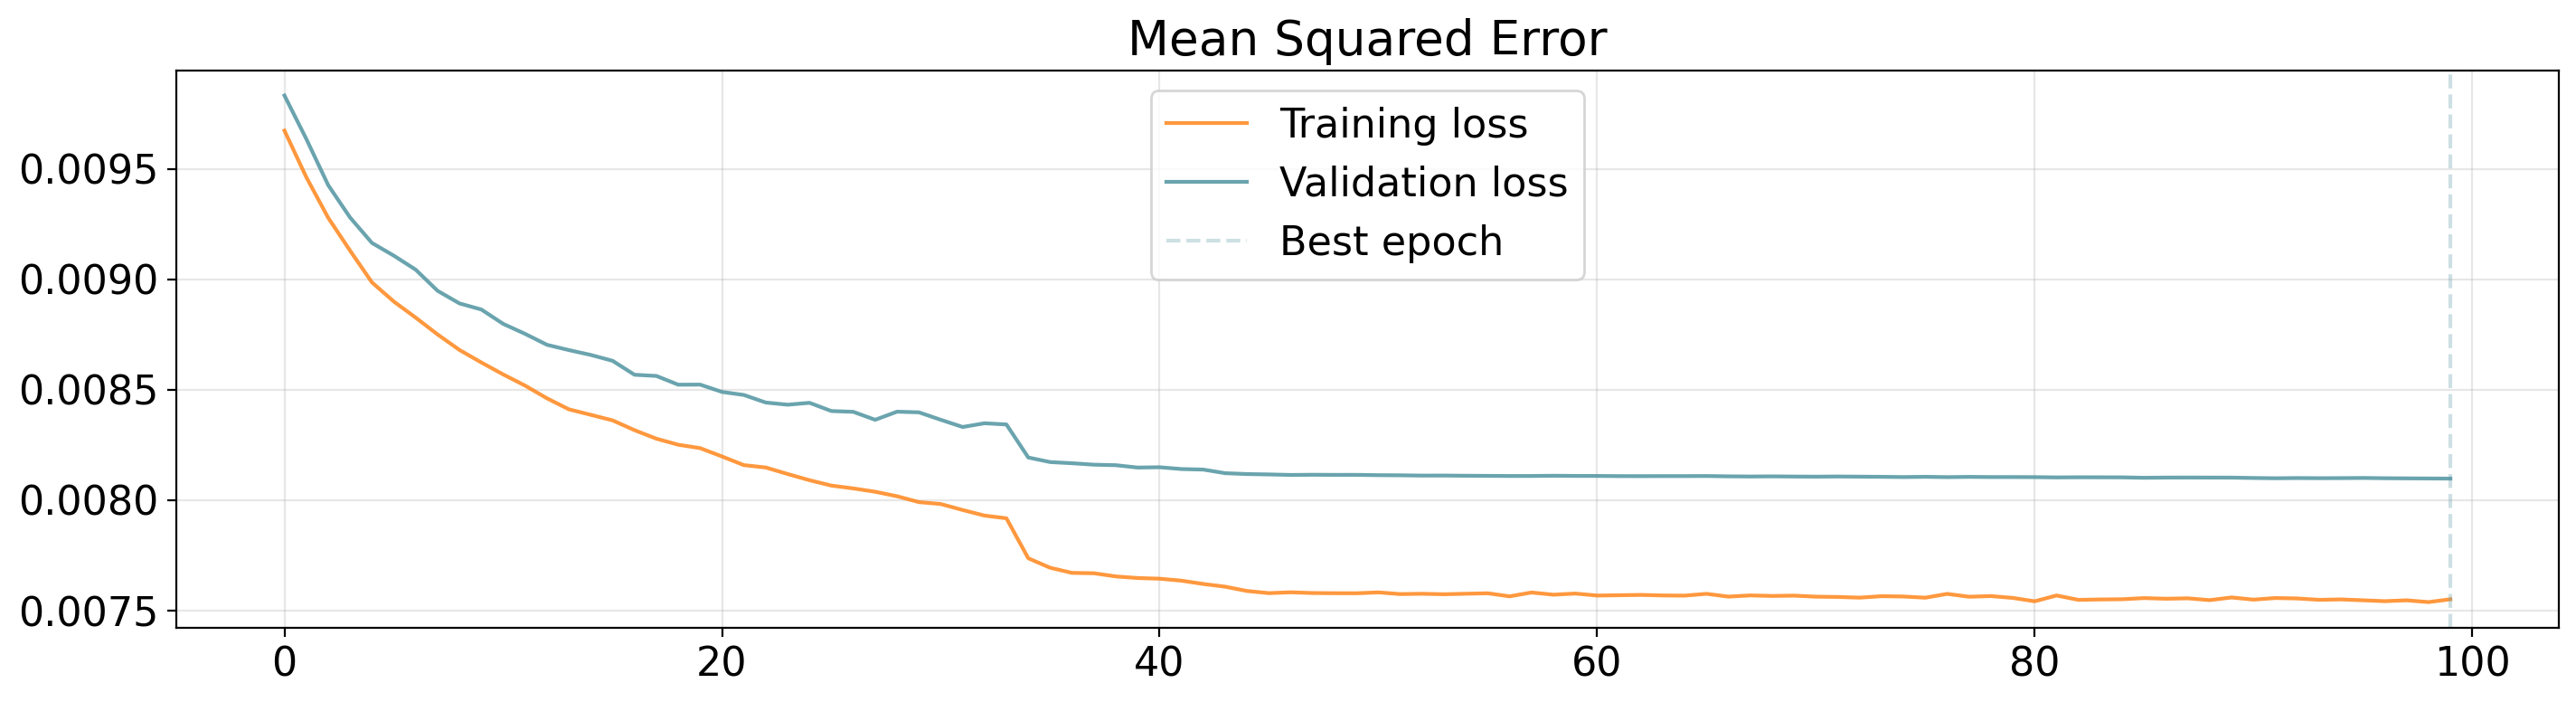

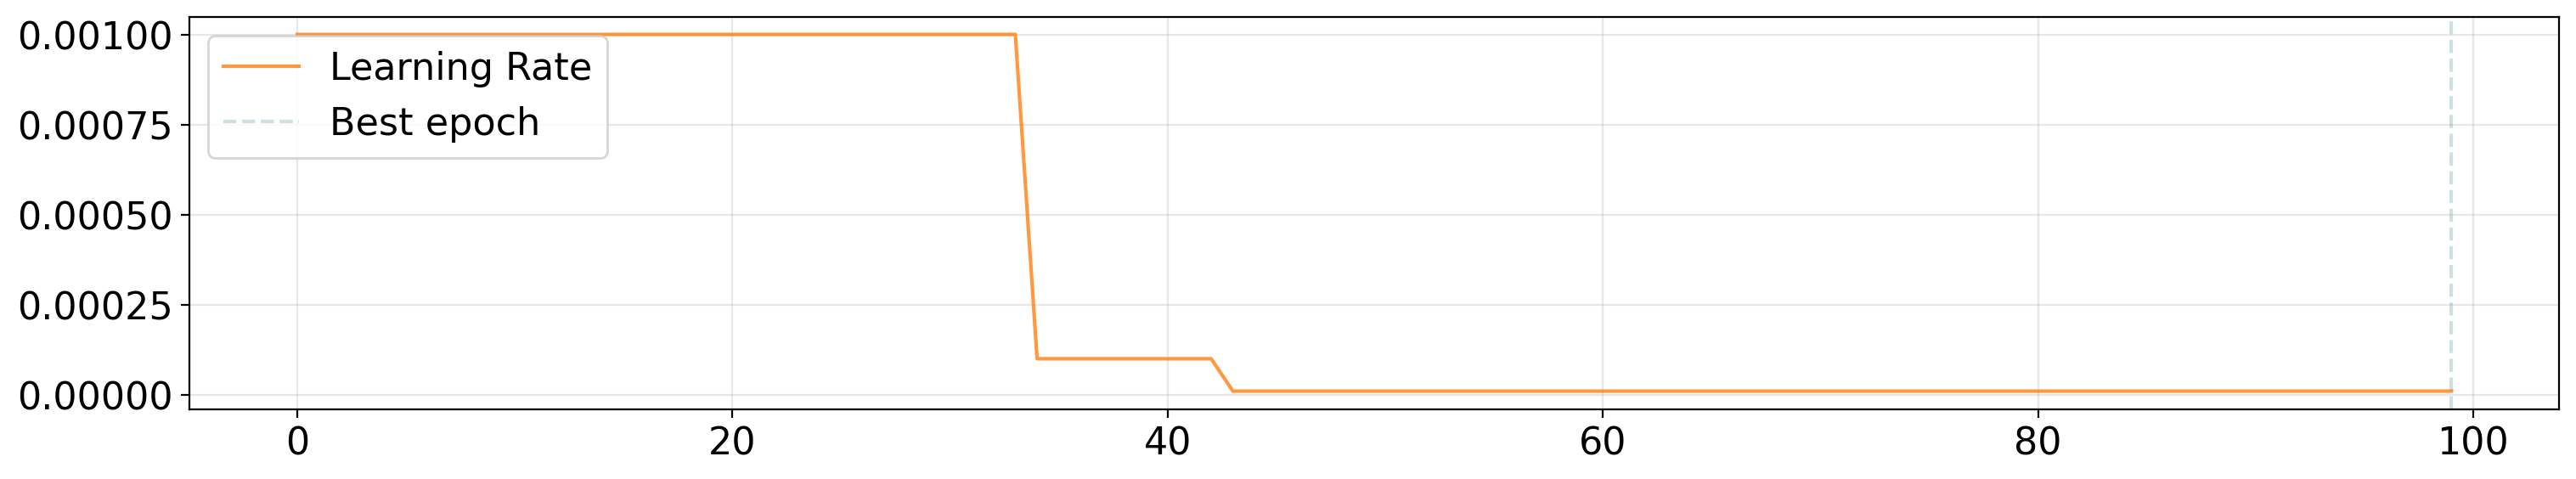

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/ch2/AR_AR")

#TRANSFER LEARNING ULTIME 9 COL MODELLO 0.40

In [ ]:
model_AR0 = tfk.models.load_model("/content/drive/MyDrive/ch2/simpleAR/SubmissionModel/simple_AR0")
model_AR0_trainable = tfk.models.load_model("/content/drive/MyDrive/ch2/simpleAR/SubmissionModel/simple_AR0")
model_0 = tfk.models.load_model("/content/drive/MyDrive/ch2/simpleAR/SubmissionModel/simple0")
model_0_trainable = tfk.models.load_model("/content/drive/MyDrive/ch2/simpleAR/SubmissionModel/simple0")

for layer in model_AR0.layers:
    layer.trainable = False

for layer in model_0.layers:
    layer.trainable = False

model_AR0._name = 'cacca'
model_AR0_trainable._name = 'diopo'
model_0_trainable._name = 'diomad'

In [ ]:

def custom_loss(target_y, pred_y):
  losses = tf.square(target_y - pred_y)
  weights = [0, 1]
  weights = np.array([weights[0]]*9 + [weights[1]]*9)
  return tf.reduce_mean(losses*weights)


def build_CONV_LSTM_model(input_shape, output_shape,l2_lambda = 2e-5):
    # Define the input layer with the specified shape
    categories = 6

    input_layer = tf.keras.Input(shape=(input_shape), name='input_layer')
    m9 = model_0(input_layer)
    m9 = tfkl.Reshape((9, 1))(m9)
    m9 = tfkl.Lambda(lambda x: x[:, -4:], output_shape=(4,1))(m9)

    m5= model_AR0(input_layer)
    m5 = tfkl.Reshape((5, 1))(m5)

    mtot = tfkl.concatenate((m5, m9), axis = 1)

    input1 = tfkl.Lambda(lambda x: x[:, 9:-categories], output_shape=output_shape)(input_layer)
    cat = tfkl.Lambda(lambda x: x[:, -categories:], output_shape=(6,1))(input_layer)
    input1 = tfkl.concatenate([input1, mtot, cat], axis = 1)
    print(input1.shape)

    n9 = model_0_trainable(input1)
    n9 = tfkl.Reshape((9, 1))(n9)
    n9 = tfkl.Lambda(lambda x: x[:, -4:], output_shape=(4,1))(n9)

    n5= model_AR0_trainable(input1)
    n5 = tfkl.Reshape((5, 1))(n5)

    ntot = tfkl.concatenate((n5, n9), axis = 1)


    #ntot = tfkl.Reshape((9, ))(ntot)

    output_layer = tfkl.concatenate((mtot, ntot), axis =1)
    output_layer = tfkl.Reshape((18, ))(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model_2')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=custom_loss, optimizer=tf.keras.optimizers.Adam())

    return model

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
#print(input_shape,output_shape)
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()



(None, 206, 1)
Model: "CONV_LSTM_model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 206, 1)]             0         []                            
                                                                                                  
 CONV_LSTM_model (Functiona  (None, 9)                    85266     ['input_layer[0][0]']         
 l)                                                                                               
                                                                                                  
 cacca (Functional)          (None, 5)                    84462     ['input_layer[0][0]']         
                                                                                                  
 reshape_10 (Reshape)        (None, 9, 1)                 0        

In [ ]:
# Train the model)
cb = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5)]
history = model.fit(
    x = train_tf,
    validation_data = validation_tf,
    epochs = 100,
    callbacks = cb,
    verbose = 1,
    validation_steps=None,
    shuffle=False,
).history

In [ ]:
# Train the model)
cb = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5)]
history = model.fit(
    x = train_tf,
    validation_data = validation_tf,
    epochs = 1,
    callbacks = cb,
    verbose = 1,
    validation_steps=None,
    shuffle=False,
).history

193/193 [==============================] - 25s 129ms/step - loss: 0.0072 - val_loss: 0.0079 - lr: 1.0000e-05


In [ ]:
model.save("/content/drive/MyDrive/ch2/AR_AR_true")

In [56]:
model_ar = tfk.models.load_model("/content/drive/MyDrive/ch2/AR_AR_true", compile = False)

1/1 [==============================] - 0s 189ms/step


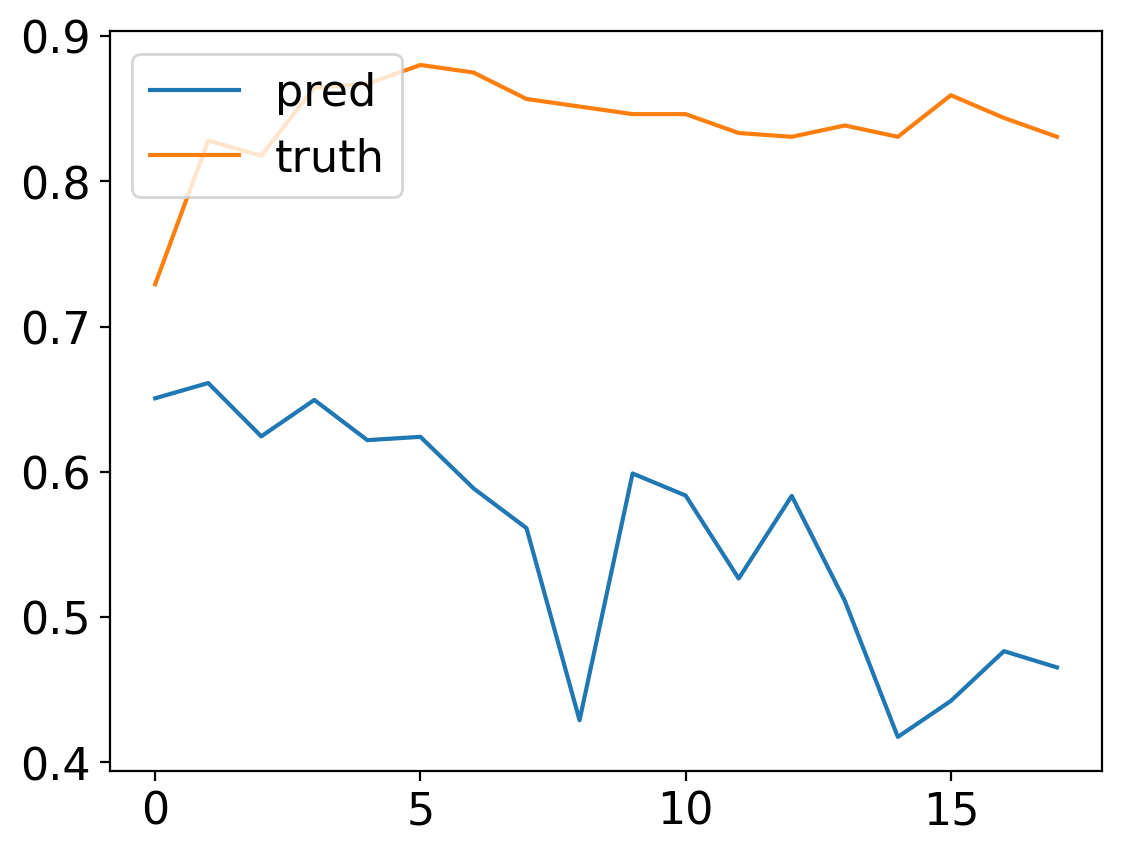

In [84]:
#idx = np.random.randint(1, 8414)
i = 100
X_test_uno = X_val[i]
#X_test_uno.shape
pred = np.squeeze(model_ar.predict(np.expand_dims(X_test_uno, axis = 0)))
plt.plot(pred, label = 'pred')

plt.plot(y_val[idx], label = 'truth')
plt.legend(loc="upper left")
